# Jonathan Halverson
# Keeping it Fresh: Predict Restaurant Inspections
## Part 2b: Computing the correlation time of the violations

In this notebook we compute the correlation time of the violations:

$$\frac{<x(t) - x_0><x(0) - x_0>}{<x(0) - x_0><x(0) - x_0>} \sim exp(-t / \tau)$$

Here is the format of the data:

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
plt.style.use('halverson')

In [2]:
from helper_methods import drop_duplicate_inspections

df = pd.read_csv('data/training_labels.txt', parse_dates=['date'])
df = df.sort_values(['restaurant_id', 'date'])
df = drop_duplicate_inspections(df, threshold=60)
df = df[(df.date >= pd.to_datetime('2008-01-01')) & (df.date <= pd.to_datetime('2014-12-31'))]
df.head()

,id,date,restaurant_id,*,**,***
551,24765,2008-03-26,0ZED0WED,3,1,0
5460,25193,2008-10-08,0ZED0WED,6,2,4
3641,12775,2009-03-03,0ZED0WED,3,0,0
18452,25850,2009-07-23,0ZED0WED,1,0,2
10227,17443,2009-12-02,0ZED0WED,3,1,1


In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 18330 entries, 551 to 5854
Data columns (total 6 columns):
id               18330 non-null int64
date             18330 non-null datetime64[ns]
restaurant_id    18330 non-null object
*                18330 non-null int64
**               18330 non-null int64
***              18330 non-null int64
dtypes: datetime64[ns](1), int64(4), object(1)
memory usage: 1002.4+ KB


### Below are two samples of the violation data

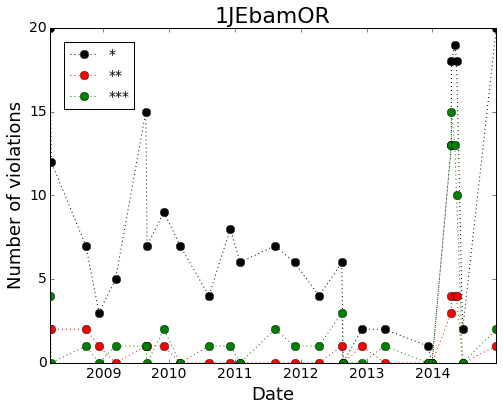

In [14]:
plt.plot(df[df.restaurant_id == '1JEbamOR'].date, df[df.restaurant_id == '1JEbamOR']['*'], 'k:', label='*', marker='o')
plt.plot(df[df.restaurant_id == '1JEbamOR'].date, df[df.restaurant_id == '1JEbamOR']['**'], 'r:', label='**', marker='o')
plt.plot(df[df.restaurant_id == '1JEbamOR'].date, df[df.restaurant_id == '1JEbamOR']['***'], 'g:', label='***', marker='o')
plt.xlabel('Date')
plt.ylabel('Number of violations')
plt.legend(loc='upper left')
plt.title('1JEbamOR')

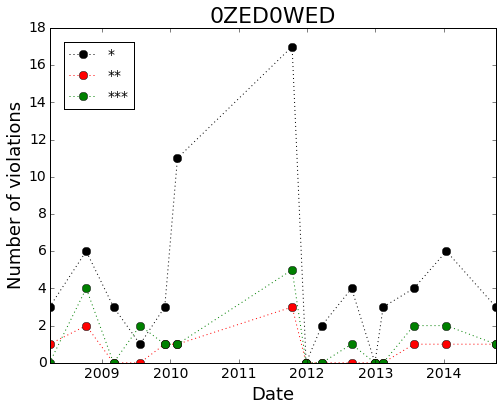

In [15]:
plt.plot(df[df.restaurant_id == '0ZED0WED'].date, df[df.restaurant_id == '0ZED0WED']['*'], 'k:', label='*', marker='o')
plt.plot(df[df.restaurant_id == '0ZED0WED'].date, df[df.restaurant_id == '0ZED0WED']['**'], 'r:', label='**', marker='o')
plt.plot(df[df.restaurant_id == '0ZED0WED'].date, df[df.restaurant_id == '0ZED0WED']['***'], 'g:', label='***', marker='o')
plt.xlabel('Date')
plt.ylabel('Number of violations')
plt.legend(loc='upper left')
plt.title('0ZED0WED')

### Let's look for a seasonal dependence

First load the weather data:

In [6]:
# https://www.wunderground.com/history/airport/KBOS/2015/1/1/CustomHistory.html
bos_wthr = pd.read_csv('data/boston_weather_2015_2011.csv', parse_dates=['EST'])
bos_wthr['weekofyear'] = bos_wthr['EST'].apply(lambda x: x.weekofyear)
bos_wthr.head(3).transpose()

,0,1,2
EST,2015-01-01 00:00:00,2015-01-02 00:00:00,2015-01-03 00:00:00
Max TemperatureF,33,41,37
Mean TemperatureF,28,36,30
Min TemperatureF,22,31,22
Max Dew PointF,16,17,36
MeanDew PointF,8,15,20
Min DewpointF,5,11,8
Max Humidity,53,53,100
Mean Humidity,43,45,72
Min Humidity,32,37,43


In [7]:
df['weekofyear'] = df.date.apply(lambda x: x.weekofyear)
weekofyear_violations = df.groupby('weekofyear').agg({'*':[np.size, np.mean], '**':[np.mean], '***':[np.mean]})
weekofyear_violations.head()

*                 ***        **
           size      mean      mean      mean
weekofyear                                   
1           985  1.302538  0.279188  0.088325
2           404  4.198020  0.871287  0.331683
3           306  3.836601  0.934641  0.297386
4           296  3.675676  0.979730  0.293919
5           361  3.495845  0.806094  0.246537

(0, 100)

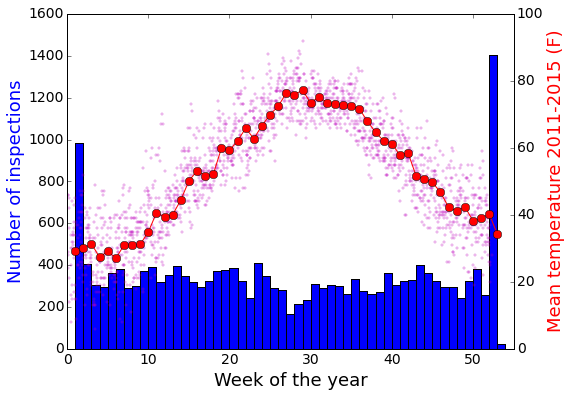

In [27]:
fig, ax1 = plt.subplots()
ax1.bar(weekofyear_violations.index, weekofyear_violations[('*', 'size')], width=1)
ax1.set_xlabel('Week of the year')
ax1.set_ylabel('Number of inspections', color='b')

mean_T_by_week = bos_wthr.groupby('weekofyear').agg({'Mean TemperatureF': [np.mean]})
ax2 = ax1.twinx()
ax2.plot(bos_wthr.EST.apply(lambda x: x.dayofyear / 7.0), bos_wthr['Mean TemperatureF'], 'm.', alpha=0.25, ms=5)
ax2.plot(mean_T_by_week.index, mean_T_by_week, 'r', marker='o')
ax2.set_ylabel('Mean temperature 2011-2015 (F)', color='r')
ax2.set_xlim(0, 55)
ax2.set_ylim(0, 100)

In [9]:
from scipy.stats import pearsonr, spearmanr
print pearsonr(mean_T_by_week[('Mean TemperatureF', 'mean')][1:-2], weekofyear_violations[('*', 'size')][1:-2])
print spearmanr(mean_T_by_week[('Mean TemperatureF', 'mean')], weekofyear_violations[('*', 'size')])

(-0.43814189867823206, 0.0014609177196348215)
SpearmanrResult(correlation=-0.40707287411533266, pvalue=0.0024858060689667521)


There is a moderate inverse correlation between the number of inspections and the mean weekly temperature. Note that when the first and last weeks are not removed the Pearson result is much different -- not surprising since it is sensitive to outliers.

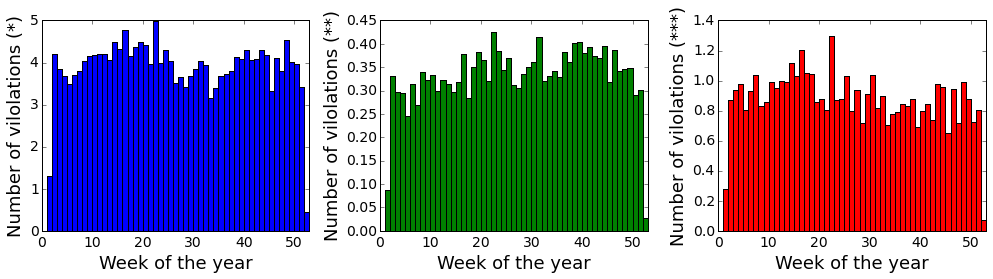

In [10]:
colors = ['b', 'g', 'r']
stars = ['*', '**', '***']
fig, ax = plt.subplots(nrows=1, ncols=3, figsize=(14, 4))
for i in range(3):
    ax[i].bar(weekofyear_violations.index, weekofyear_violations[(stars[i], 'mean')], width=1, color=colors[i])
    ax[i].set_xlabel('Week of the year')
    ax[i].set_ylabel('Number of violations (' + stars[i] + ')')
    ax[i].set_xlim(0, 53)
plt.tight_layout()

In [11]:
for star in stars:
    print star, pearsonr(mean_T_by_week[('Mean TemperatureF', 'mean')][1:-2], weekofyear_violations[(star, 'mean')][1:-2])
    print star, spearmanr(mean_T_by_week[('Mean TemperatureF', 'mean')], weekofyear_violations[(star, 'mean')])

* (-0.13692453449929373, 0.34303274277546314)
* SpearmanrResult(correlation=-0.03942912433478471, pvalue=0.77923767231156149)
** (0.49089444947898747, 0.00029517538955575344)
** SpearmanrResult(correlation=0.52128688921141753, pvalue=6.2730652555874128e-05)
*** (-0.16357373540316802, 0.25635379249186552)
*** SpearmanrResult(correlation=-0.064828253507498795, pvalue=0.64466334091563149)


### Compute the correlation time

In [38]:
df = df.sort_values(['restaurant_id', 'date'])
df.head()

,id,date,restaurant_id,*,**,***,weekofyear
551,24765,2008-03-26,0ZED0WED,3,1,0,13
5460,25193,2008-10-08,0ZED0WED,6,2,4,41
3641,12775,2009-03-03,0ZED0WED,3,0,0,10
18452,25850,2009-07-23,0ZED0WED,1,0,2,30
10227,17443,2009-12-02,0ZED0WED,3,1,1,49


For each restaurant compute average * then loop over all time origins and compute t_diff and <x-x_0><x-x_0> then plot and fit to exponential then compute tau which is the decorrelation time which will be less than the average time between inspections.

Need dictionary to store t_diff (in weeks between dates).

In [73]:
d = df[df.restaurant_id == '0ZED0WED']
d.reset_index(inplace=True, drop=True)
d

,id,date,restaurant_id,*,**,***,weekofyear
0,24765,2008-03-26,0ZED0WED,3,1,0,13
1,25193,2008-10-08,0ZED0WED,6,2,4,41
2,12775,2009-03-03,0ZED0WED,3,0,0,10
3,25850,2009-07-23,0ZED0WED,1,0,2,30
4,17443,2009-12-02,0ZED0WED,3,1,1,49
5,4180,2010-02-08,0ZED0WED,11,1,1,6
6,3527,2011-10-14,0ZED0WED,17,3,5,41
7,22246,2011-12-28,0ZED0WED,0,0,0,52
8,17990,2012-03-21,0ZED0WED,2,0,0,12
9,1601,2012-08-27,0ZED0WED,4,0,1,35


In [34]:
mean_one_star = d.mean()['*']
mean_one_star

4.4000000000000004

In [35]:
num_inspect = d.shape[0]

In [46]:
for index, row in d.iterrows():
    print row['*']

3
6
3
1
3
11
17
0
2
4
0
3
4
6
3


In [66]:
d

,id,date,restaurant_id,*,**,***,weekofyear
551,24765,2008-03-26,0ZED0WED,3,1,0,13
5460,25193,2008-10-08,0ZED0WED,6,2,4,41
3641,12775,2009-03-03,0ZED0WED,3,0,0,10
18452,25850,2009-07-23,0ZED0WED,1,0,2,30
10227,17443,2009-12-02,0ZED0WED,3,1,1,49
11543,4180,2010-02-08,0ZED0WED,11,1,1,6
20637,3527,2011-10-14,0ZED0WED,17,3,5,41
14848,22246,2011-12-28,0ZED0WED,0,0,0,52
21555,17990,2012-03-21,0ZED0WED,2,0,0,12
6720,1601,2012-08-27,0ZED0WED,4,0,1,35


In [84]:
from collections import defaultdict
ct = defaultdict(int)
cf = defaultdict(int)

for i in range(num_inspect - 1):
    one_star = d.ix[i, '*'] - mean_one_star
    t_start = d.ix[i, 'date']
    for j in range(i + 1, num_inspect):
        t_diff = int((d.ix[j, 'date'] - t_start) / np.timedelta64(1, 'W'))
        cf[t_diff] += (d.ix[j, '*'] - mean_one_star) * one_star
        ct[t_diff] += 1

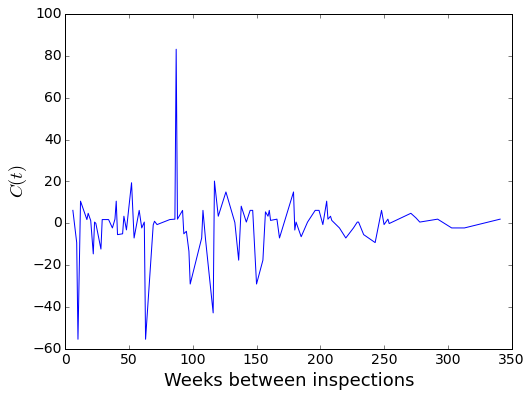

In [92]:
plt.plot(ct.keys(), [cf[t] / ct[t] for t in ct.keys()])
plt.xlabel('Weeks between inspections')
plt.ylabel('$C(t)$')